In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from itertools import groupby, count

sys.path.append('../../src')

from utils.formatter import rename_columns, pivot_database, apply_sct_gain
from utils.functions import clean_folder, load_datasets_from_csv
from di.functions import append_di_column
from plot import show_serie
from paths import DB_DIR, FMTD_DB_DIR, FXD_DB_DIR

In [2]:
clean_folder(FXD_DB_DIR, "*.csv")

In [3]:
dts = load_datasets_from_csv(FMTD_DB_DIR).copy()

<AxesSubplot:>

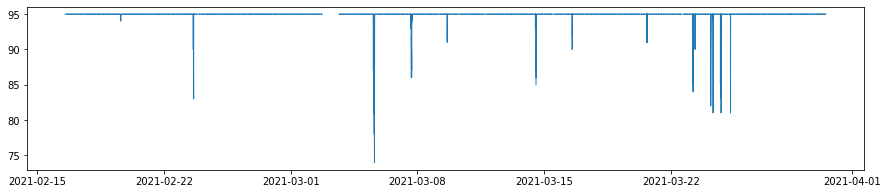

In [4]:
# DHT11 humidity data is invalid
show_serie(dts['house']['H'])

<AxesSubplot:>

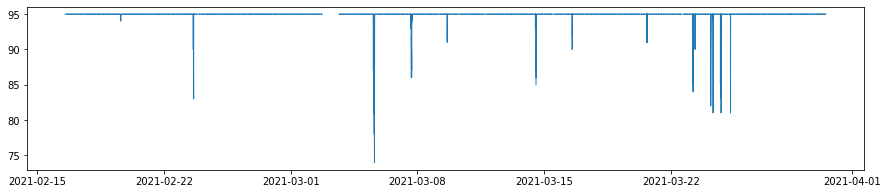

In [5]:
show_serie(dts['pump']['H'])

In [6]:
# Searching the most correlate environment with the ambient where DHT11 with wrong data was
# "house" corresponds to the courtyard ambient, where the DHT11 was

a = dts['house']['T'].corr(dts['computer']['T'])
b = dts['house']['T'].corr(dts['external']['T'])
c = dts['house']['T'].corr(dts['fridge']['T'])

# The most correlated ambient found was "computer" ambient.
print(a, b, c)

0.967366180459045 0.9328857343052038 0.8690161947744548


In [7]:
## Using a simple Rule of Three, as as shown,

\begin{align}
\ H_h & = \frac{H_c}{T_c}\times T_h \         
\end{align}


In [8]:
# FIX DHT11 HUMIDITY DATA
data = pd.concat([dts['computer'][['T','H']] , dts['house']['T']], keys=['Quarto2','Pátio'], axis=1)
new_h = (data['Quarto2']['H']/data['Quarto2']['T'])*data['Pátio']['T']

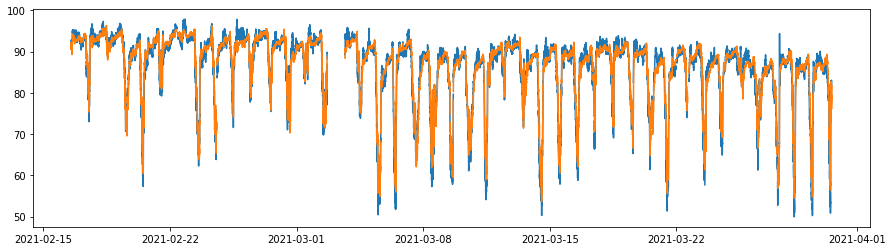

In [9]:
# Showing new humidity (blue) and old house humidity (orange)
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(new_h)
plt.plot(data['Quarto2']['H'])

In [10]:
# Checking Covariance and Correlation between "House" temperature and "New" humidity
corr = dts['house']['T'].corr(new_h)
cov = dts['house']['T'].cov(new_h)
print("Corr: {:.2f}, Cov: {:.2f}".format(corr, cov))

Corr: -0.83, Cov: -15.61


In [11]:
# Checking Covariance and Correlation between "House" temperature and "Computer" humidity
corr = dts['house']['T'].corr(dts['computer']['H'])
cov = dts['house']['T'].cov(dts['computer']['H'])
print("Corr: {:.2f}, Cov: {:.2f}".format(corr, cov))

Corr: -0.89, Cov: -14.99


In [12]:
# "New" humidity was chosed
dts['house']['H'] = new_h
dts['pump']['H'] = new_h

<AxesSubplot:>

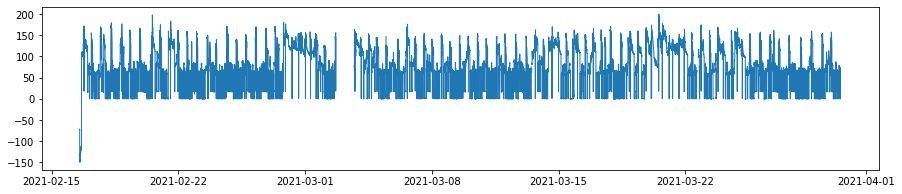

In [13]:
#Due to wrong installation, the first data samples are inverted
show_serie(dts['fridge']['Pwr'])

In [14]:
# Fixing
fg_pwr=dts['fridge']['Pwr']
dts['fridge']['Pwr'] = np.where(fg_pwr.index < '2021-02-16 15:50:00', abs(fg_pwr), fg_pwr)

<AxesSubplot:>

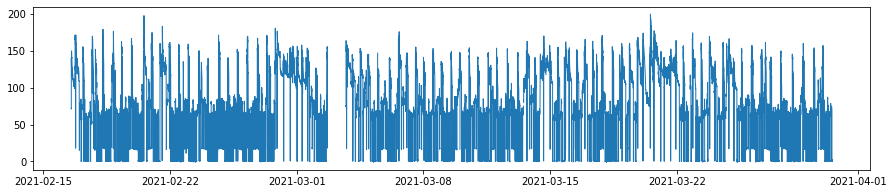

In [15]:
# Showing
show_serie(dts['fridge']['Pwr'])

In [16]:
# Export data
for key in dts:
    dts[key].to_csv(FXD_DB_DIR+"/{}.csv".format(key), float_format='%.4f')